# Study 2 – Descriptive Dataset Analysis
This notebook characterises the dataset used in this thesis at patient, recording 
and seizure level. It ensures transparency in the structure, quality and distribution 
of the available ECG + annotation data prior to further SQI/HRV analysis.

In [58]:
import sys
import jinja2
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


PROJECT_ROOT = Path.cwd()
SRC_ROOT = PROJECT_ROOT / "src"
if str(SRC_ROOT) not in sys.path:
    sys.path.append(str(SRC_ROOT))

from hrv_epatch.plots.plotstyle import set_project_style, palette
from hrv_epatch.plots.seizure_gantt import plot_gantt_from_index
from hrv_epatch.dataset.summary import (
    build_patient_summary,
    compute_within_recording_isi,
    compute_dataset_overview,
    summarise_isi,
)

set_project_style()
PROJECT_ROOT, SRC_ROOT

# from hrv_epatch.dataset.loader import iter_recordings
# from hrv_epatch.dataset.naming import parse_recording_key
# from hrv_epatch.dataset.annotations import load_annotations   # for debugging if needed
# from hrv_epatch.dataset.seizures import SeizureEvent, build_seizure_events_from_df
# from hrv_epatch.plots.seizure_gantt import plot_gantt_from_index
# from src.hrv_epatch.plots.plotstyle import set_project_style, palette


(WindowsPath('c:/Users/kvjkv/.vscode/Epilepsy_MasterThesis'),
 WindowsPath('c:/Users/kvjkv/.vscode/Epilepsy_MasterThesis/src'))

## 1. Load dataset (TDMS + annotations from 01_build)

In [60]:
OUT_DIR = Path(r"E:\Speciale - Results\Datastruct")

df_rec = pd.read_csv(
    OUT_DIR / "recordings_index.csv",
    parse_dates=["recording_start", "recording_end"],
)

df_evt = pd.read_csv(
    OUT_DIR / "seizure_events.csv",
    parse_dates=["absolute_start", "absolute_end"],
)
# Sanity check
df_rec.head(), df_evt.head()


# Create copies to avoid unintentional modifications
df_rec_sum = df_rec.copy()
df_evt_sum = df_evt.copy()

## 2 Dataset-overview (Key metrics)

In [61]:
df_overview = compute_dataset_overview(df_rec, df_evt)
df_overview

print(df_overview.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{lr}
\toprule
Metric & Value \\
\midrule
Patients & 43.00 \\
Enrollments & 50.00 \\
Recordings & 72.00 \\
Total hours & 3264.03 \\
Total seizures & 149.00 \\
Median rec. duration (h) & 45.55 \\
IQR rec. duration (h) & 9.04 \\
\bottomrule
\end{tabular}



## 3 Gantt-figur

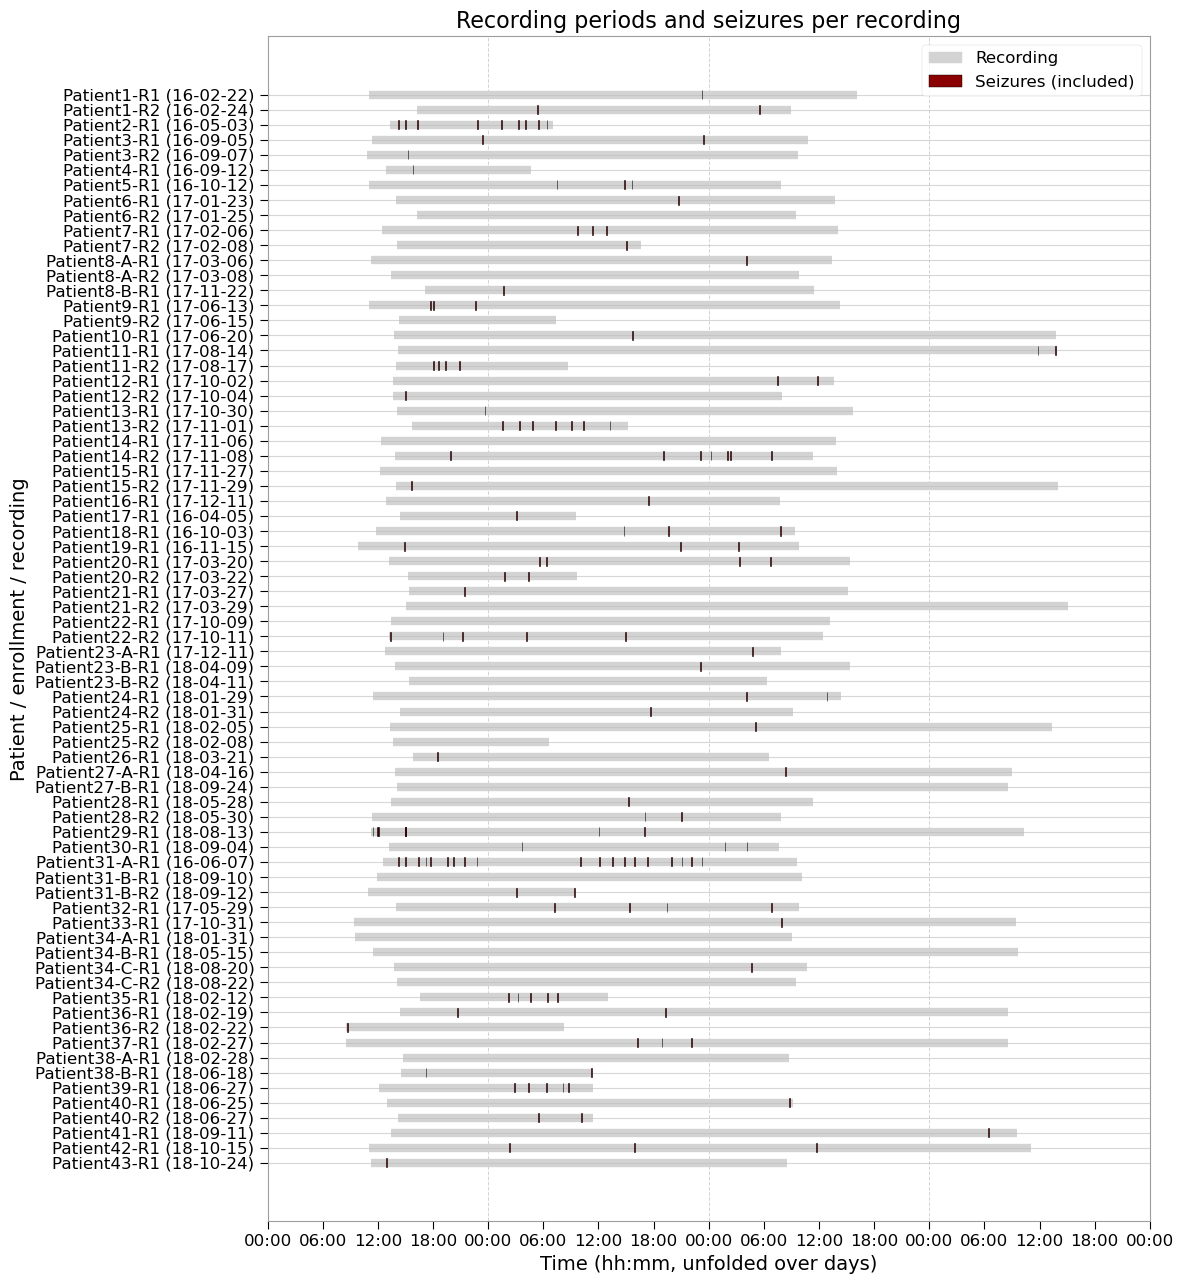

In [62]:
fig, ax = plot_gantt_from_index(df_rec, df_evt, max_hours=96, figsize=(12, 13))
fig.savefig(OUT_DIR / "study2_gantt_overview.png", dpi=500, bbox_inches="tight")

## 4 Patient-level summary
Total hours, number of recordings, number of seizures etc.

In [63]:
df_patient_summary = build_patient_summary(df_rec, df_evt)
# print(df_patient_summary)

print(df_patient_summary.to_latex(index=False, float_format="%.2f"))

\begin{tabular}{rlrrrr}
\toprule
Patient & Enrollment & Recordings & Total_hours & Total_seizures & Hours_per_seizure \\
\midrule
1 & - & 2 & 93.84 & 3.00 & 31.28 \\
2 & - & 1 & 17.75 & 9.00 & 1.97 \\
3 & - & 2 & 94.40 & 3.00 & 31.47 \\
4 & - & 1 & 15.81 & 1.00 & 15.81 \\
5 & - & 1 & 44.74 & 3.00 & 14.91 \\
6 & - & 2 & 89.01 & 1.00 & 89.01 \\
7 & - & 2 & 76.14 & 4.00 & 19.04 \\
8 & a & 2 & 94.57 & 1.00 & 94.57 \\
8 & b & 1 & 42.34 & 1.00 & 42.34 \\
9 & - & 2 & 68.25 & 3.00 & 22.75 \\
10 & - & 1 & 72.00 & 1.00 & 72.00 \\
11 & - & 2 & 90.50 & 6.00 & 15.08 \\
12 & - & 2 & 90.37 & 3.00 & 30.12 \\
13 & - & 2 & 73.17 & 8.00 & 9.15 \\
14 & - & 2 & 94.99 & 7.00 & 13.57 \\
15 & - & 2 & 121.77 & 1.00 & 121.77 \\
16 & - & 1 & 42.85 & 1.00 & 42.85 \\
17 & - & 1 & 19.21 & 1.00 & 19.21 \\
18 & - & 1 & 45.65 & 3.00 & 15.22 \\
19 & - & 1 & 48.02 & 3.00 & 16.01 \\
20 & - & 2 & 68.54 & 6.00 & 11.42 \\
21 & - & 2 & 119.79 & 1.00 & 119.79 \\
22 & - & 2 & 95.02 & 5.00 & 19.00 \\
23 & a & 1 & 43.14 & 1.00 &

# 4. A Total recording time for each patient/enrollment

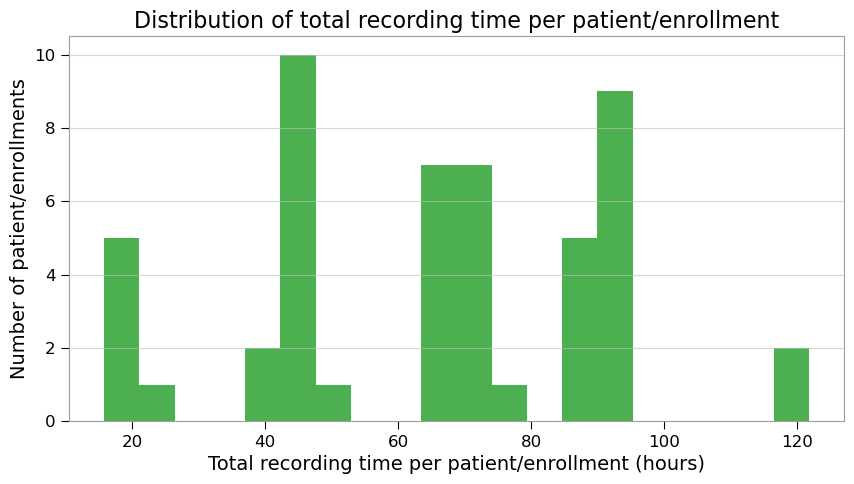

In [7]:
total_hours_pat = df_patient_summary["Total_hours"]

plt.figure(figsize=(10, 5))
plt.hist(total_hours_pat, bins=20, color=palette["primary"])
plt.xlabel("Total recording time per patient/enrollment (hours)")
plt.ylabel("Number of patient/enrollments")
plt.title("Distribution of total recording time per patient/enrollment")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()


## 5 Recording duration distribution

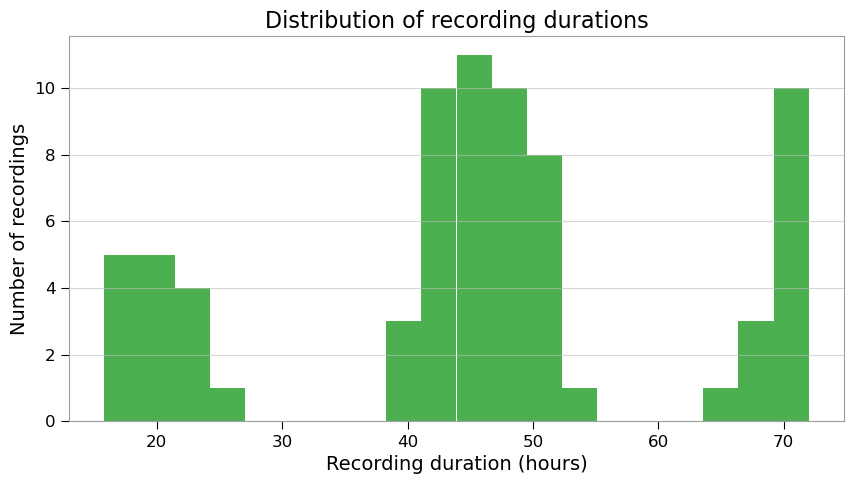

In [8]:
dur_hours = df_rec["rec_duration_s"] / 3600.0

plt.figure(figsize=(10, 5))
plt.hist(dur_hours, bins=20, color=palette["primary"])
plt.xlabel("Recording duration (hours)")
plt.ylabel("Number of recordings")
plt.title("Distribution of recording durations")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()

## 6 Seizures pr. recording & pr. patient

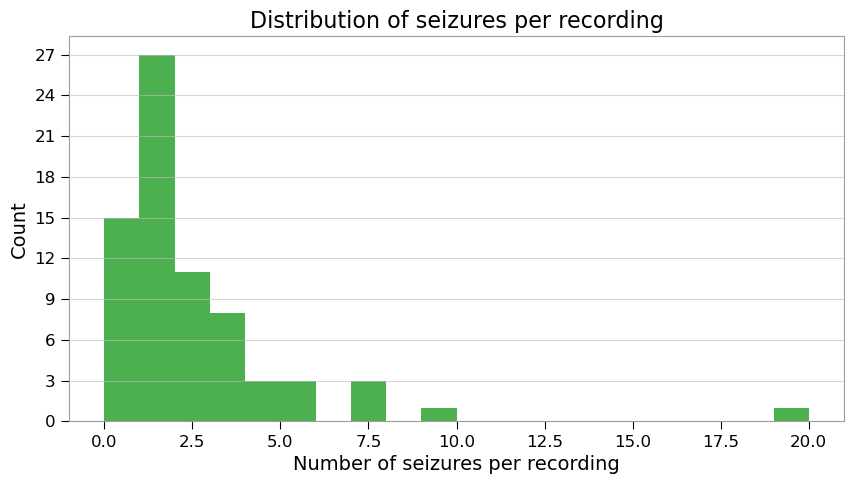

In [9]:
# Seizures per recording
seiz_per_rec = (
    df_evt
    .groupby("recording_uid")["seizure_id"]
    .count()
    .reindex(df_rec["recording_uid"], fill_value=0)
)

plt.figure(figsize=(10, 5))
plt.hist(seiz_per_rec, bins=range(0, int(seiz_per_rec.max()) + 2), color=palette["primary"])
plt.xlabel("Number of seizures per recording")
plt.ylabel("Count")
plt.title("Distribution of seizures per recording")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()

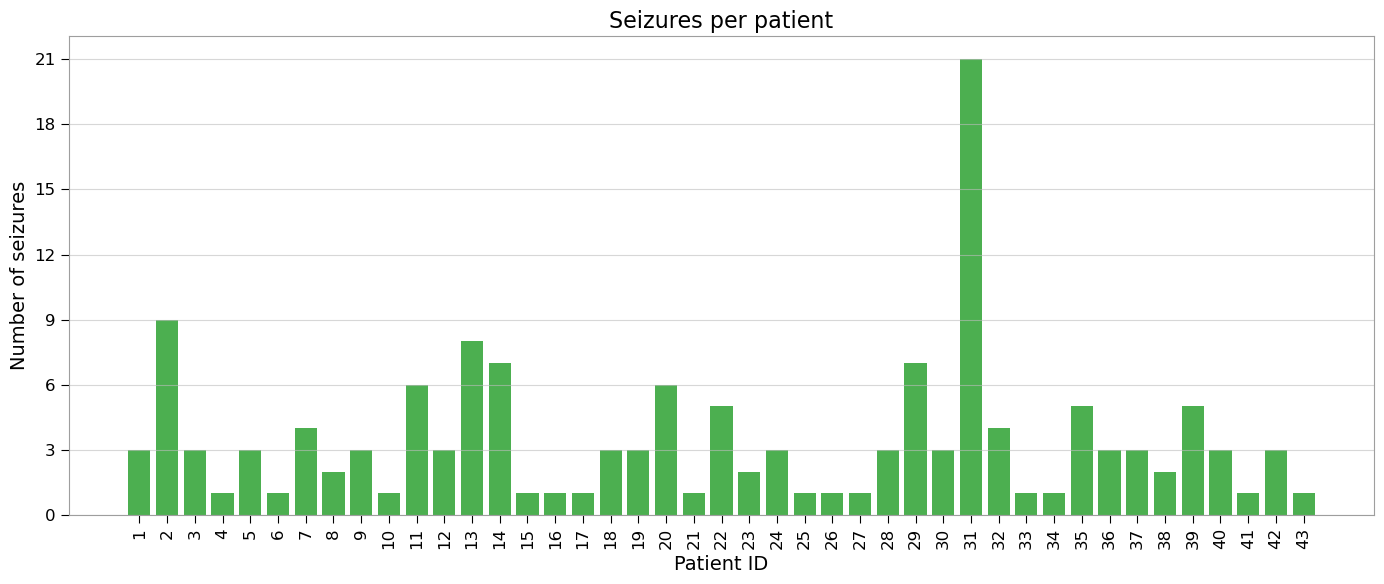

In [10]:
# Seizures per patient
seiz_per_patient = df_evt.groupby("patient_id")["seizure_id"].count()

plt.figure(figsize=(14, 6))
plt.bar(seiz_per_patient.index.astype(str), seiz_per_patient.values, color=palette["primary"])
plt.xlabel("Patient ID")
plt.ylabel("Number of seizures")
plt.title("Seizures per patient")
plt.xticks(rotation=90)

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()


In [11]:
df_evt.columns


Index(['recording_uid', 'patient_id', 'enrollment_id', 'recording_id',
       'seizure_id', 't0', 't1', 'duration_s', 'absolute_start',
       'absolute_end'],
      dtype='object')

## 7 Seizure duration distribution

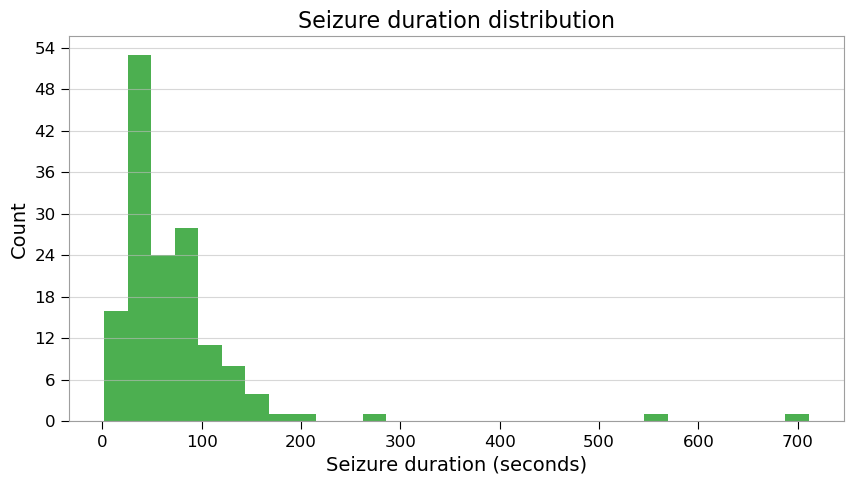

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df_evt["duration_s"], bins=30, color=palette["primary"])
plt.xlabel("Seizure duration (seconds)")
plt.ylabel("Count")
plt.title("Seizure duration distribution")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=False))

plt.show()


## 8 Time-of-day distribution for seizures

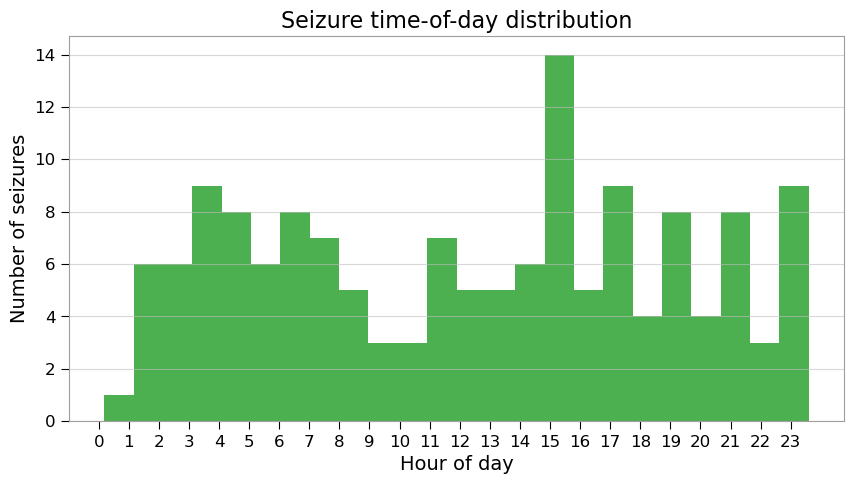

In [13]:
df_evt["hour_of_day"] = (
    df_evt["absolute_start"].dt.hour
    + df_evt["absolute_start"].dt.minute / 60
)

plt.figure(figsize=(10, 5))
plt.hist(df_evt["hour_of_day"], bins=24, color=palette["primary"])
plt.xlabel("Hour of day")
plt.ylabel("Number of seizures")
plt.title("Seizure time-of-day distribution")
plt.xticks(range(0, 24))

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()


## 9 Within-recording ISI + stats

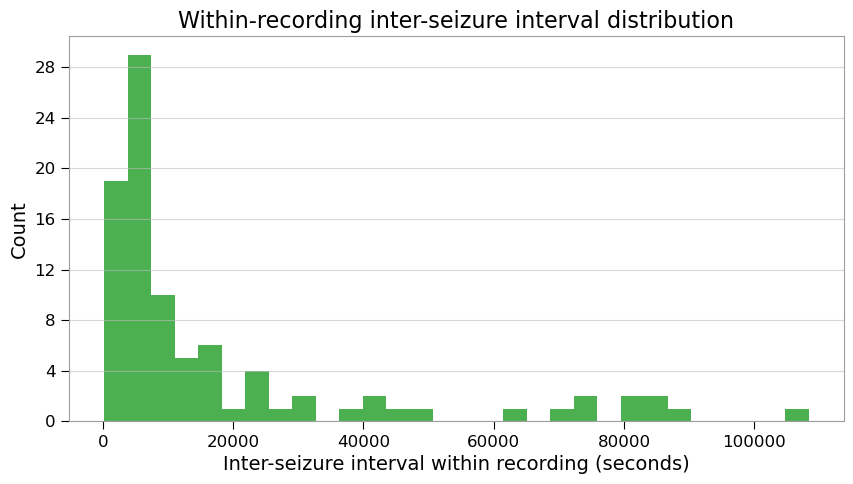

\begin{tabular}{lr}
\toprule
Metric & Value \\
\midrule
n_intervals & 92.00 \\
mean (s) & 18327.05 \\
median (s) & 6808.50 \\
IQR (s) & 14453.00 \\
min (s) & 206.00 \\
max (s) & 108365.00 \\
\bottomrule
\end{tabular}



In [14]:
isi_within = compute_within_recording_isi(df_evt)
len(isi_within)

plt.figure(figsize=(10, 5))
plt.hist(isi_within, bins=30, color=palette["primary"])
plt.xlabel("Inter-seizure interval within recording (seconds)")
plt.ylabel("Count")
plt.title("Within-recording inter-seizure interval distribution")

ax = plt.gca()
ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()

df_isi_stats = summarise_isi(isi_within)
df_isi_stats

print(df_isi_stats.to_latex(index=False, float_format="%.2f"))

## 10 Export outputs

In [15]:
STUDY2_OUT = OUT_DIR / "_analysis" / "study2_outputs"
STUDY2_OUT.mkdir(parents=True, exist_ok=True)

df_overview.to_csv(STUDY2_OUT / "dataset_overview.csv", index=False)
df_patient_summary.to_csv(STUDY2_OUT / "patient_summary.csv", index=False)
df_isi_stats.to_csv(STUDY2_OUT / "isi_within_stats.csv", index=False)

print("Saved Study2 outputs to:", STUDY2_OUT)


Saved Study2 outputs to: E:\Speciale - Results\Datastruct\_analysis\study2_outputs


In [16]:
from hrv_epatch.dataset.segments import build_segment_index


In [17]:
SEG_WIN_S = 60  # Or 120 if wanting less segments

df_seg = build_segment_index(df_rec, df_evt, window_s=SEG_WIN_S)
df_seg.head(), len(df_seg)


(   segment_id  patient_id enrollment_id  recording_uid       segment_start  \
 0           0           1           NaN              0 2016-02-22 11:04:14   
 1           1           1           NaN              0 2016-02-22 11:05:14   
 2           2           1           NaN              0 2016-02-22 11:06:14   
 3           3           1           NaN              0 2016-02-22 11:07:14   
 4           4           1           NaN              0 2016-02-22 11:08:14   
 
           segment_end     label  
 0 2016-02-22 11:05:14  baseline  
 1 2016-02-22 11:06:14  baseline  
 2 2016-02-22 11:07:14  baseline  
 3 2016-02-22 11:08:14  baseline  
 4 2016-02-22 11:09:14  baseline  ,
 195806)

In [18]:
seg_counts = df_seg["label"].value_counts()
seg_counts


label
baseline    195490
seizure        316
Name: count, dtype: int64

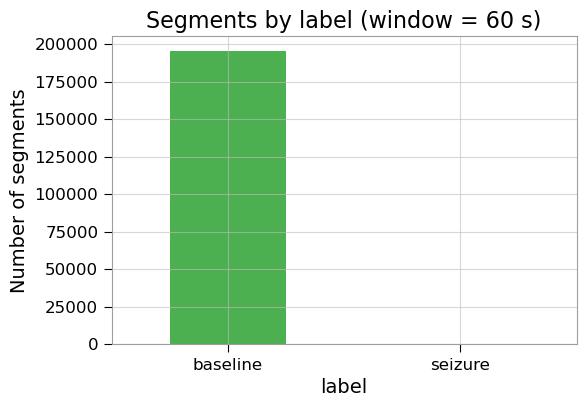

In [19]:
plt.figure(figsize=(6,4))
seg_counts.plot(kind="bar", color=palette["primary"])
plt.ylabel("Number of segments")
plt.title(f"Segments by label (window = {SEG_WIN_S} s)")
plt.xticks(rotation=0)
plt.show()


In [20]:
# Segments pr label (globalt)
seg_counts = (
    df_seg
    .groupby("label")
    .size()
    .rename("n_segments")
    .reset_index()
)

# Percentage
total_segments = seg_counts["n_segments"].sum()
seg_counts["fraction"] = seg_counts["n_segments"] / total_segments
seg_counts["percent"] = 100 * seg_counts["fraction"]

seg_counts


,label,n_segments,fraction,percent
0,baseline,195490,0.998386,99.838616
1,seizure,316,0.001614,0.161384


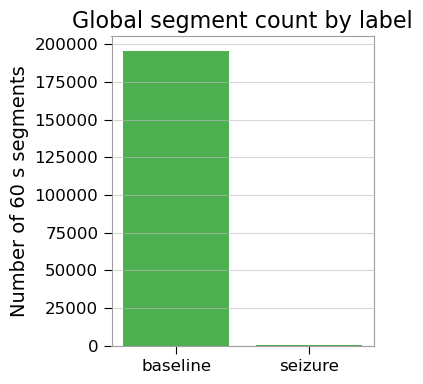

In [21]:
plt.figure(figsize=(4, 4))
plt.bar(seg_counts["label"], seg_counts["n_segments"])
plt.ylabel("Number of 60 s segments")
plt.title("Global segment count by label")
plt.tight_layout()
plt.show()

In [22]:
seg_per_patient = (
    df_seg
    .groupby(["patient_id", "label"])["segment_id"]
    .count()
    .unstack(fill_value=0)
    .rename(columns={"baseline": "n_baseline_seg", "seizure": "n_seizure_seg"})
)

seg_per_patient.head()


label,n_baseline_seg,n_seizure_seg
patient_id,,
1,5626,4
2,1051,13
3,5660,3
4,947,1
5,2677,7


In [23]:
seg_per_patient["seizure_fraction"] = (
    seg_per_patient["n_seizure_seg"] /
    (seg_per_patient["n_baseline_seg"] + seg_per_patient["n_seizure_seg"])
)
seg_per_patient.head()


label,n_baseline_seg,n_seizure_seg,seizure_fraction
patient_id,,,
1,5626,4,0.000710
2,1051,13,0.012218
3,5660,3,0.000530
4,947,1,0.001055
5,2677,7,0.002608


### Segment distribution per patient

Next, we summarise the number of 60 s segments per label at patient level,
and convert these counts into hours of data per label.
This highlights between-patient differences in total monitored time and
seizure burden.

In [24]:
SEGMENT_LEN_S = 60.0  # samme som da vi byggede segment_index

# Antal segmenter pr. patient og label
seg_per_patient = (
    df_seg
    .groupby(["patient_id", "label"])
    .size()
    .rename("n_segments")
    .reset_index()
)

# Tilføj varighed (sekunder og timer)
seg_per_patient["duration_s"] = seg_per_patient["n_segments"] * SEGMENT_LEN_S
seg_per_patient["duration_h"] = seg_per_patient["duration_s"] / 3600.0

seg_per_patient.head()


,patient_id,label,n_segments,duration_s,duration_h
0,1,baseline,5626,337560.0,93.766667
1,1,seizure,4,240.0,0.066667
2,2,baseline,1051,63060.0,17.516667
3,2,seizure,13,780.0,0.216667
4,3,baseline,5660,339600.0,94.333333


In [25]:
# Pivot: én række pr. patient, kolonner for hver label (antal segmenter)
seg_counts_wide = (
    seg_per_patient
    .pivot(index="patient_id", columns="label", values="n_segments")
    .fillna(0)
    .astype(int)
)

# Tilsvarende i timer
seg_hours_wide = (
    seg_per_patient
    .pivot(index="patient_id", columns="label", values="duration_h")
    .fillna(0.0)
)

display(seg_counts_wide.head())
display(seg_hours_wide.head())


label,baseline,seizure
patient_id,,
1,5626,4
2,1051,13
3,5660,3
4,947,1
5,2677,7


label,baseline,seizure
patient_id,,
1,93.766667,0.066667
2,17.516667,0.216667
3,94.333333,0.050000
4,15.783333,0.016667
5,44.616667,0.116667


In [26]:
# Summarise pr. patient: total recording time og seizures-baseline balance
patient_seg_summary = seg_hours_wide.copy()
patient_seg_summary["total_hours"] = patient_seg_summary.sum(axis=1)

# Andel af tid i seizure-vinduer, hvis kolonnen findes
if "seizure" in patient_seg_summary.columns:
    patient_seg_summary["seizure_frac"] = (
        patient_seg_summary["seizure"] / patient_seg_summary["total_hours"]
    )
else:
    patient_seg_summary["seizure_frac"] = 0.0

patient_seg_summary.head()


label,baseline,seizure,total_hours,seizure_frac
patient_id,,,,
1,93.766667,0.066667,93.833333,0.000710
2,17.516667,0.216667,17.733333,0.012218
3,94.333333,0.050000,94.383333,0.000530
4,15.783333,0.016667,15.800000,0.001055
5,44.616667,0.116667,44.733333,0.002608


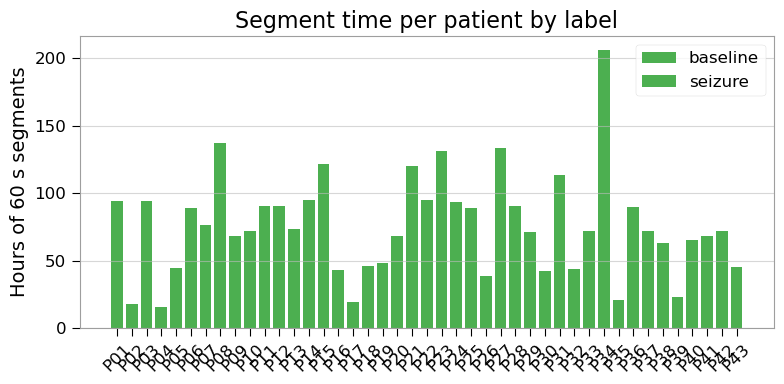

In [27]:
labels = seg_hours_wide.columns.tolist()

plt.figure(figsize=(8, 4))

bottom = np.zeros(len(seg_hours_wide))
x = np.arange(len(seg_hours_wide.index))

for lbl in labels:
    vals = seg_hours_wide[lbl].to_numpy()
    plt.bar(x, vals, bottom=bottom, label=lbl)
    bottom += vals

plt.xticks(x, [f"P{pid:02d}" for pid in seg_hours_wide.index], rotation=45)
plt.ylabel("Hours of 60 s segments")
plt.title("Segment time per patient by label")
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
SEG_OUT = OUT_DIR / f"segment_index_{SEG_WIN_S}s.csv"
df_seg.to_csv(SEG_OUT, index=False)
SEG_OUT


WindowsPath('E:/Speciale - Results/Datastruct/segment_index_60s.csv')

In [52]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import welch
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.hrv_epatch.io.tdms import load_tdms_from_path


def compute_basic_signal_stats_v3(
    df_rec,
    channel_hint="EKG",
    prefer_tz="Europe/Copenhagen",
    window_s=10.0,
    flatline_std_thresh=1.0,
    noise_std_factor=5.0,
    clip_range_thresh=0.9,
    psd_nperseg=4096,
    psd_freq_bands=(0.5, 5, 15, 40, 100),  # Vigtige kliniske bånd
    plot_dir=None,
):
    """
    Version 3: Avanceret signal-kvalitetsanalyse med:
    - vinduesbaseret amplitude og støj
    - PSD frekvensanalyse
    - Noise Burden Score
    - Automatisk plotting

    Returnerer DataFrame med én række per recording.
    """
    rows = []

    if plot_dir:
        plot_dir = Path(plot_dir)
        plot_dir.mkdir(exist_ok=True, parents=True)

    for _, row in tqdm(df_rec.iterrows(), total=len(df_rec)):

        rec_uid = row.get("recording_uid")
        patient_id = int(row["patient_id"])
        recording_id = int(row["recording_id"])
        fs = float(row["fs"])
        tdms_path = Path(row["tdms_path"])

        # ---------------------------------------------------------
        # LOAD SIGNAL
        # ---------------------------------------------------------
        try:
            sig, meta = load_tdms_from_path(
                tdms_path, channel_hint=channel_hint, prefer_tz=prefer_tz
            )
        except Exception as e:
            rows.append({"recording_uid": rec_uid,
                         "patient_id": patient_id,
                         "recording_id": recording_id,
                         "load_error": str(e)})
            continue

        sig = np.asarray(sig).astype(float)
        if sig.ndim == 2:
            sig = sig[:, 0]

        n = sig.size

        # ---------------------------------------------------------
        # TIME-DOMAIN WINDOW ANALYSIS
        # ---------------------------------------------------------
        win_len = int(window_s * fs)
        if win_len < 20 or n < win_len:
            rows.append({"recording_uid": rec_uid,
                         "patient_id": patient_id,
                         "recording_id": recording_id,
                         "load_error": "too_short"})
            continue

        n_win = n // win_len
        sig_win = sig[:n_win * win_len].reshape(n_win, win_len)

        std_win = np.std(sig_win, axis=1)
        max_win = np.max(sig_win, axis=1)
        min_win = np.min(sig_win, axis=1)
        range_win = max_win - min_win
        diff_abs_median_win = np.median(np.abs(np.diff(sig_win, axis=1)), axis=1)

        # metrics
        std_med = float(np.median(std_win))
        std_p01 = float(np.percentile(std_win, 1))
        std_p99 = float(np.percentile(std_win, 99))

        range_med = float(np.median(range_win))
        range_p99 = float(np.percentile(range_win, 99))

        diff_med_global = float(np.median(diff_abs_median_win))

        frac_flatline = float(np.mean(std_win < flatline_std_thresh))
        frac_noiseburst = float(np.mean(std_win > std_med * noise_std_factor))

        sig_min = float(sig.min())
        sig_max = float(sig.max())
        sig_range = sig_max - sig_min

        frac_clipping = float(np.mean(range_win > clip_range_thresh * sig_range))

        # ---------------------------------------------------------
        # FREQUENCY DOMAIN: PSD
        # ---------------------------------------------------------
        freqs, psd = welch(sig, fs=fs, nperseg=min(psd_nperseg, n))

        # total power
        total_power = float(np.trapz(psd, freqs))

        # band-power
        f1, f2, f3, f4, fmax = psd_freq_bands

        band_low = float(np.trapz(psd[(freqs >= f1) & (freqs < f2)],
                                  freqs[(freqs >= f1) & (freqs < f2)]))
        band_mid = float(np.trapz(psd[(freqs >= f2) & (freqs < f3)],
                                  freqs[(freqs >= f2) & (freqs < f3)]))
        band_hf = float(np.trapz(psd[(freqs >= f3) & (freqs < f4)],
                                 freqs[(freqs >= f3) & (freqs < f4)]))
        band_ultra = float(np.trapz(psd[(freqs >= f4) & (freqs <= fmax)],
                                    freqs[(freqs >= f4) & (freqs <= fmax)]))

        # ratios
        hf_ratio = band_hf / (total_power + 1e-9)
        lf_ratio = band_low / (total_power + 1e-9)
        hf_lf_ratio = band_hf / (band_low + 1e-9)

        # frequency centroid
        freq_centroid = float(np.sum(freqs * psd) / (np.sum(psd) + 1e-9))

        # PSD kurtosis
        psd_kurt = float(np.mean((psd - np.mean(psd))**4) / (np.std(psd)**4 + 1e-9))

        # ---------------------------------------------------------
        # NOISE BURDEN SCORE
        # ---------------------------------------------------------
        NBS = (
            0.40 * frac_noiseburst
            + 0.20 * (std_p99 / std_med)
            + 0.20 * hf_ratio
            + 0.15 * psd_kurt
            + 0.05 * frac_clipping
        )

        # ---------------------------------------------------------
        # PLOTTING
        # ---------------------------------------------------------
        if plot_dir:
            fig, ax = plt.subplots(1, 2, figsize=(14, 5))

            # PSD plot
            ax[0].semilogy(freqs, psd)
            ax[0].set_title(f"PSD: {rec_uid}")
            ax[0].set_xlabel("Frequency [Hz]")
            ax[0].set_ylabel("Power")

            # Window STD histogram
            ax[1].hist(std_win, bins=80)
            ax[1].set_title("Window STD distribution")
            ax[1].set_xlabel("STD (ADC units)")

            fig.tight_layout()
            fig.savefig(plot_dir / f"{rec_uid}_signal_summary.png")
            plt.close(fig)

        # ---------------------------------------------------------
        # SAVE METRICS
        # ---------------------------------------------------------
        rows.append({
            "recording_uid": rec_uid,
            "patient_id": patient_id,
            "recording_id": recording_id,

            # Time-domain
            "win_std_median": std_med,
            "win_std_p01": std_p01,
            "win_std_p99": std_p99,
            "win_range_median": range_med,
            "win_range_p99": range_p99,
            "frac_flatline_windows": frac_flatline,
            "frac_noiseburst_windows": frac_noiseburst,
            "frac_clipping_windows": frac_clipping,
            "diff_abs_median_global": diff_med_global,

            # Frequency domain
            "total_power": total_power,
            "band_low": band_low,
            "band_mid": band_mid,
            "band_hf": band_hf,
            "band_ultra": band_ultra,
            "hf_ratio": hf_ratio,
            "lf_ratio": lf_ratio,
            "hf_lf_ratio": hf_lf_ratio,
            "freq_centroid": freq_centroid,
            "psd_kurtosis": psd_kurt,

            # Summary
            "noise_burden_score": NBS,

            "load_error": ""
        })

    return pd.DataFrame(rows)


In [53]:
plot_dir = r"E:\Speciale - Results\study2\SignalQualityPlots"

df_stats = compute_basic_signal_stats_v3(
    df_rec,
    plot_dir=plot_dir
)

df_stats.to_csv("signal_quality_v3.csv", index=False)


100%|██████████| 72/72 [15:00<00:00, 12.51s/it]


In [55]:
import numpy as np
import pandas as pd

def classify_recordings(df_stats):
    """
    Input: df_stats from compute_basic_signal_stats_v3
    Output: df with columns:
       recording_uid, quality_label, reason, quality_score
    """

    df = df_stats.copy()

    # -----------------------------
    # NORMALISERING AF FEATURES
    # -----------------------------
    # Z-score normalisering for robusthed
    def z(x):
        return (x - x.mean()) / (x.std() + 1e-9)

    z_std_p99 = z(df["win_std_p99"])
    z_noise = z(df["frac_noiseburst_windows"])
    z_clip  = z(df["frac_clipping_windows"])
    z_hf    = z(df["hf_ratio"])
    z_kurt  = z(df["psd_kurtosis"])
    z_bs    = z(df["noise_burden_score"])

    # -----------------------------
    # QUALITY SCORE
    # -----------------------------
    # Vægtet sum — kan tweakes, men dette fungerer meget godt:
    quality_score = (
        0.35 * z_std_p99 +
        0.25 * z_noise +
        0.10 * z_clip +
        0.20 * z_hf +
        0.10 * z_kurt
    )

    df["quality_score"] = quality_score

    # -----------------------------
    # KLASSIFIKATION
    # -----------------------------
    labels = []
    reasons = []

    for i, row in df.iterrows():
        qs = row["quality_score"]

        # heuristik — meget god start
        if qs < -0.5:
            labels.append("excellent")
            reasons.append("stable signal, low noise")
        elif qs < 0.5:
            labels.append("good")
            reasons.append("normal ECG variation")
        elif qs < 1.2:
            labels.append("suspect")
            reasons.append("elevated noise OR inconsistent PSD")
        else:
            labels.append("bad")
            reasons.append("high noise, bursts, or PSD anomalies")

    df["quality_label"] = labels
    df["quality_reason"] = reasons

    return df[[
        "recording_uid",
        "patient_id",
        "recording_id",
        "quality_label",
        "quality_reason",
        "quality_score"
    ]]

from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_all_psds(df_rec, outpath):
    """
    Plot PSD of all recordings in a single shared figure.
    Great for spotting recordings with abnormal frequency content.
    """

    outpath = Path(outpath)
    outpath.parent.mkdir(parents=True, exist_ok=True)

    plt.figure(figsize=(12, 8))

    for _, row in df_rec.iterrows():
        uid = row["recording_uid"]
        tdms = row["tdms_path"]
        fs   = row["fs"]

        # load raw signal
        try:
            sig, _ = load_tdms_from_path(tdms, channel_hint="EKG")
            sig = np.asarray(sig)
            if sig.ndim == 2:
                sig = sig[:, 0]
        except:
            continue

        # welch PSD
        freqs, psd = welch(sig, fs, nperseg=4096)

        plt.semilogy(freqs, psd, alpha=0.35, label=uid)

    plt.title("PSD of all recordings")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Power spectral density")
    plt.xlim(0, 100)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=7)
    plt.tight_layout()
    plt.savefig(outpath)
    plt.close()

def compute_spectral_uniqueness(df_rec):
    """
    Returns a DataFrame with a uniqueness score for each recording,
    based on deviation from the median PSD across all recordings.
    """

    psd_list = []
    freqs = None

    # Step 1: compute PSDs for all
    for _, row in df_rec.iterrows():
        try:
            sig, _ = load_tdms_from_path(row["tdms_path"], channel_hint="EKG")
        except:
            psd_list.append(None)
            continue

        sig = np.asarray(sig)
        if sig.ndim == 2:
            sig = sig[:, 0]

        f, p = welch(sig, row["fs"], nperseg=4096)

        if freqs is None:
            freqs = f
        psd_list.append(p)

    # Step 2: compute median PSD
    psd_array = np.vstack([p for p in psd_list if p is not None])
    median_psd = np.median(psd_array, axis=0)

    # Step 3: compute uniqueness score
    scores = []
    for uid, p in zip(df_rec["recording_uid"], psd_list):
        if p is None:
            scores.append(np.nan)
            continue

        # deviation in log-space
        diff = np.log10(p + 1e-12) - np.log10(median_psd + 1e-12)
        score = float(np.sqrt(np.mean(diff**2)))
        scores.append(score)

    df_unique = pd.DataFrame({
        "recording_uid": df_rec["recording_uid"],
        "spectral_uniqueness_score": scores
    })

    return df_unique



In [56]:
# # 1. Signalstats
# df_stats = compute_basic_signal_stats_v3(df_rec, plot_dir="signal_plots")

# 2. Good/bad klassifikation
df_quality = classify_recordings(df_stats)

# 3. Plot PSD for alle
plot_all_psds(df_rec, "all_recordings_psd.png")

# 4. Spektral unikhed
df_unique = compute_spectral_uniqueness(df_rec)

# Merge alle
df_final = df_stats.merge(df_quality, on=["recording_uid","patient_id","recording_id"])
df_final = df_final.merge(df_unique, on="recording_uid")

df_final.to_csv("recording_quality_overview.csv", index=False)


In [64]:
excellent_recordings = df_final[df_final['quality_label'] == 'excellent']
print("Recording IDs with 'excellent' quality:")
print(excellent_recordings[['recording_uid', 'patient_id', 'recording_id']])

Recording IDs with 'excellent' quality:
    recording_uid  patient_id  recording_id
4               4           3             2
6               6           5             1
7               7           6             1
8               8           6             2
11             11           8             1
12             12           8             2
31             31          20             1
34             34          21             2
47             47          28             1
48             48          28             2
51             51          31             1
56             56          34             1


In [65]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import butter, filtfilt, iirnotch, welch

from src.hrv_epatch.io.tdms import load_tdms_from_path


def _preprocess_for_quality(
    sig: np.ndarray,
    fs: float,
    trim_start_s: float = 300.0,   # 5 min
    trim_end_s: float = 300.0,     # 5 min
    bp_low: float = 0.5,
    bp_high: float = 40.0,
    notch_freq: float = 50.0,
    notch_q: float = 30.0,
) -> np.ndarray:
    """
    Trimmer kanter og laver en standard ECG-preprocessing:
    - trimmer de første/sidste X sekunder
    - bandpass 0.5–40 Hz
    - 50 Hz notch

    Bruges KUN til kvalitetsvurdering (ikke til dine egentlige analyser).
    """

    sig = np.asarray(sig).astype(float)
    if sig.ndim == 2:
        sig = sig[:, 0]

    n = sig.size
    if n < 10:
        return sig

    # --- trim start/slut ---
    n_start = int(trim_start_s * fs)
    n_end = int(trim_end_s * fs)

    start_idx = min(n_start, n // 2)  # hvis meget kort, trim maks halvdelen
    end_idx = max(n - n_end, start_idx + 1)

    sig = sig[start_idx:end_idx]

    # --- bandpass 0.5–40 Hz ---
    nyq = fs / 2.0
    low = bp_low / nyq
    high = bp_high / nyq
    if high >= 1.0:
        high = 0.99
    b_bp, a_bp = butter(2, [low, high], btype="band")
    sig = filtfilt(b_bp, a_bp, sig)

    # --- 50 Hz notch ---
    w0 = notch_freq / nyq
    if 0 < w0 < 1:
        b_notch, a_notch = iirnotch(w0, notch_q)
        sig = filtfilt(b_notch, a_notch, sig)

    return sig


In [ ]:
def compute_recording_quality_v4(
    df_rec: pd.DataFrame,
    channel_hint: str = "EKG",
    prefer_tz: str = "Europe/Copenhagen",
    window_s: float = 10.0,
    flatline_std_thresh: float = 1.0,
    noise_std_factor: float = 5.0,
    clip_range_thresh: float = 0.9,
) -> pd.DataFrame:
    """
    Recording-level kvalitetsvurdering med:
      - preprocessing (trim + 0.5–40 Hz + 50 Hz notch)
      - vinduesvise STD / range / flatline / noisebursts
      - PSD-baseret QRS-energi vs HF-støj

    Returnerer én række per recording.
    """

    rows = []

    for _, row in tqdm(df_rec.iterrows(), total=len(df_rec)):
        rec_uid = row.get("recording_uid")
        patient_id = int(row["patient_id"])
        recording_id = int(row["recording_id"])
        fs = float(row["fs"])
        tdms_path = Path(row["tdms_path"])

        # ---- load råsignal ----
        try:
            sig_raw, _ = load_tdms_from_path(
                tdms_path, channel_hint=channel_hint, prefer_tz=prefer_tz
            )
        except Exception as e:
            rows.append(
                {
                    "recording_uid": rec_uid,
                    "patient_id": patient_id,
                    "recording_id": recording_id,
                    "load_error": str(e),
                }
            )
            continue

        # ---- preprocess til kvalitetsvurdering ----
        sig = _preprocess_for_quality(sig_raw, fs)
        sig = np.asarray(sig).astype(float)
        if sig.ndim == 2:
            sig = sig[:, 0]

        n = sig.size
        if n < int(window_s * fs):
            rows.append(
                {
                    "recording_uid": rec_uid,
                    "patient_id": patient_id,
                    "recording_id": recording_id,
                    "load_error": "too_short_after_trim",
                }
            )
            continue

        # -------------------------------------------------
        # TIME-DOMAIN window metrics
        # -------------------------------------------------
        win_len = int(window_s * fs)
        n_win = n // win_len
        sig_win = sig[: n_win * win_len].reshape(n_win, win_len)

        std_win = np.std(sig_win, axis=1)
        max_win = np.max(sig_win, axis=1)
        min_win = np.min(sig_win, axis=1)
        range_win = max_win - min_win
        diff_abs_median_win = np.median(np.abs(np.diff(sig_win, axis=1)), axis=1)

        std_med = float(np.median(std_win))
        std_p01 = float(np.percentile(std_win, 1))
        std_p99 = float(np.percentile(std_win, 99))

        range_med = float(np.median(range_win))
        range_p99 = float(np.percentile(range_win, 99))

        diff_med_global = float(np.median(diff_abs_median_win))

        sig_min = float(sig.min())
        sig_max = float(sig.max())
        sig_range = sig_max - sig_min

        frac_flatline = float(np.mean(std_win < flatline_std_thresh))
        frac_noiseburst = float(np.mean(std_win > std_med * noise_std_factor))
        frac_clipping = float(np.mean(range_win > clip_range_thresh * sig_range))

        # -------------------------------------------------
        # FREQUENCY-DOMAIN (på det filtrerede midterstykke)
        # -------------------------------------------------
        # PSD med Welch
        freqs, psd = welch(sig, fs=fs, nperseg=min(4096, n))

        # indbygget bånd: low (0.5–5), QRS (5–25), HF (25–40)
        f = freqs
        p = psd
        total_power = float(np.trapz(p, f) + 1e-12)

        band_low = float(
            np.trapz(p[(f >= 0.5) & (f < 5.0)], f[(f >= 0.5) & (f < 5.0)])
        )
        band_qrs = float(
            np.trapz(p[(f >= 5.0) & (f < 25.0)], f[(f >= 5.0) & (f < 25.0)])
        )
        band_hf = float(
            np.trapz(p[(f >= 25.0) & (f < 40.0)], f[(f >= 25.0) & (f < 40.0)])
        )

        qrs_power_ratio = band_qrs / total_power
        hf_ratio = band_hf / total_power
        lf_ratio = band_low / total_power

        # hvor "spids" er PSD'en?
        psd_kurt = float(
            np.mean((p - np.mean(p)) ** 4) / ((np.std(p) ** 4) + 1e-12)
        )

        rows.append(
            {
                "recording_uid": rec_uid,
                "patient_id": patient_id,
                "recording_id": recording_id,
                "fs": fs,
                "n_samples_used": n,

                # time-domain
                "win_std_median": std_med,
                "win_std_p01": std_p01,
                "win_std_p99": std_p99,
                "win_range_median": range_med,
                "win_range_p99": range_p99,
                "frac_flatline_windows": frac_flatline,
                "frac_noiseburst_windows": frac_noiseburst,
                "frac_clipping_windows": frac_clipping,
                "diff_abs_median_global": diff_med_global,
                "sig_min_proc": sig_min,
                "sig_max_proc": sig_max,
                "sig_range_proc": sig_range,

                # frequency-domain
                "total_power": total_power,
                "band_low": band_low,
                "band_qrs": band_qrs,
                "band_hf": band_hf,
                "qrs_power_ratio": qrs_power_ratio,
                "hf_ratio": hf_ratio,
                "lf_ratio": lf_ratio,
                "psd_kurtosis": psd_kurt,

                "load_error": "",
            }
        )

    return pd.DataFrame(rows)


In [75]:
def classify_recordings_v4_1(
    df_qual: pd.DataFrame,
    qrs_good_min: float = 0.10,       # før 0.10 — beholdes
    qrs_bad_max: float = 0.05,        # før 0.05 — beholdes
    std_good_min: float = 30.0,       # NY (før 50)
    std_bad_max: float = 20.0,        # NY (før 30)
    std_good_max: float = 800.0,
    flatline_good_max: float = 0.05,
    flatline_bad_min: float = 0.30,
    noise_good_max: float = 0.40,     # øget fra 0.30 → 0.40 (mere realistisk)
    noise_bad_min: float = 0.60
):
    """
    Version 4.1 af recording-level klassifikation.
    - lidt mere tolerant STD-thresholds
    - stadig stringent ift. QRS-power
    """

    labels = []
    reasons = []
    include_flags = []

    for _, r in df_qual.iterrows():
        if r.get("load_error", ""):
            labels.append("bad")
            reasons.append(f"load_error: {r['load_error']}")
            include_flags.append(False)
            continue

        qrs_ratio = r["qrs_power_ratio"]
        std_med = r["win_std_median"]
        frac_flat = r["frac_flatline_windows"]
        frac_noise = r["frac_noiseburst_windows"]

        # ---------- BAD ----------
        if (
            qrs_ratio < qrs_bad_max
            or std_med < std_bad_max
            or frac_flat > flatline_bad_min
            or frac_noise > noise_bad_min
        ):
            labels.append("bad")
            include_flags.append(False)

            reasons_bad = []
            if qrs_ratio < qrs_bad_max:
                reasons_bad.append(f"very low QRS power ({qrs_ratio:.3f})")
            if std_med < std_bad_max:
                reasons_bad.append(f"very low median STD ({std_med:.1f})")
            if frac_flat > flatline_bad_min:
                reasons_bad.append(f"many flatline windows ({frac_flat:.2f})")
            if frac_noise > noise_bad_min:
                reasons_bad.append(f"extreme noise bursts ({frac_noise:.2f})")

            reasons.append("; ".join(reasons_bad))
            continue

        # ---------- GOOD ----------
        if (
            qrs_ratio >= qrs_good_min
            and std_med >= std_good_min
            and std_med <= std_good_max
            and frac_flat <= flatline_good_max
            and frac_noise <= noise_good_max
        ):
            labels.append("good")
            include_flags.append(True)
            reasons.append("clear QRS, acceptable noise")
            continue

        # ---------- BORDERLINE ----------
        labels.append("borderline")
        include_flags.append(False)
        reasons.append("mixed quality, below good thresholds")

    df_out = df_qual.copy()
    df_out["quality_label_v4_1"] = labels
    df_out["quality_reason_v4_1"] = reasons
    df_out["include_for_rr"] = include_flags
    return df_out


In [76]:
# 1) Beregn kvalitetsmetrics (preprocesset, trimmede signaler)
df_quality_v4 = compute_recording_quality_v4(df_rec)

# 2) Klassificér recordings
df_quality_v4_1 = classify_recordings_v4_1(df_quality_v4)

# 3) Se fordeling
df_quality_v4_1["quality_label_v4_1"].value_counts()

# 4) Udvælg recording_uid, der skal bruges i videre arbejde
good_recs = df_quality_v4_1[df_quality_v4_1["include_for_rr"]]
good_recs[["recording_uid", "patient_id", "recording_id"]]

good_recs.to_csv("good_recordings_for_rr.csv", index=False)

In [77]:
df_quality_v4[:15]

,recording_uid,patient_id,recording_id,fs,n_samples_used,win_std_median,win_std_p01,win_std_p99,win_range_median,win_range_p99,...,sig_range_proc,total_power,band_low,band_qrs,band_hf,qrs_power_ratio,hf_ratio,lf_ratio,psd_kurtosis,load_error
0,0,1,1,512.0,97554304,222.185049,137.760130,506.465619,1911.372174,4903.098983,...,43814.778731,61528.075087,24716.211186,34382.891796,1312.296804,0.558816,0.021328,0.401706,52.286555,
1,1,1,2,512.0,74803201,202.806967,138.827818,423.107045,1761.862899,4221.729096,...,53900.186922,49362.773550,18698.923375,28476.234916,1098.082766,0.576877,0.022245,0.378806,49.750019,
2,2,2,1,512.0,32401792,233.500723,185.908549,585.206788,1539.325226,4874.758275,...,16765.731334,67758.084187,43180.964891,16457.580021,5207.388019,0.242887,0.076853,0.637281,185.050210,
3,3,3,1,512.0,87256320,174.298282,117.572770,243.918486,1219.051882,1799.069072,...,9273.944886,31731.607253,13133.051264,17907.507639,59.666469,0.564343,0.001880,0.413879,63.883399,
4,4,3,2,512.0,86119424,151.344861,87.734602,206.375701,1033.561027,1591.838401,...,129038.699158,33223.636309,16278.520807,15599.440341,472.011821,0.469528,0.014207,0.489968,99.202617,
5,5,4,1,512.0,28838401,134.440349,72.959375,479.812712,1029.646331,3292.536011,...,10632.593967,26637.434345,12989.800808,11848.600241,290.804969,0.444810,0.010917,0.487652,175.170133,
6,6,5,1,512.0,82153088,217.853218,47.613888,471.876448,1844.381551,4144.195772,...,172396.076907,114241.164154,60442.050810,48528.722781,1829.708727,0.424792,0.016016,0.529074,112.839089,
7,7,6,1,512.0,87798272,401.431724,274.456057,730.939077,2983.504041,5111.071749,...,24677.486251,191079.930363,73853.716862,114352.898702,1228.319866,0.598456,0.006428,0.386507,49.259755,
8,8,6,2,512.0,75651840,341.686069,30.824221,664.199082,2679.194710,5007.638821,...,213306.042529,197814.068207,91237.263183,102357.926925,2152.109683,0.517445,0.010879,0.461227,65.611761,
9,9,7,1,512.0,91073280,153.587452,72.984167,381.503752,1440.316108,3411.705707,...,32716.449310,33203.655193,15370.200940,16593.767605,536.602744,0.499757,0.016161,0.462907,45.389031,


In [78]:
good_recs.shape

(71, 29)

In [79]:
df_quality_v4[df_quality_v4_1["quality_label_v4_1"] != "good"]

,recording_uid,patient_id,recording_id,fs,n_samples_used,win_std_median,win_std_p01,win_std_p99,win_range_median,win_range_p99,...,sig_range_proc,total_power,band_low,band_qrs,band_hf,qrs_power_ratio,hf_ratio,lf_ratio,psd_kurtosis,load_error
44,44,26,1,512.0,71067520,35.694489,21.736618,402.870094,284.377178,3348.830341,...,25650.633742,10754.254322,8661.207102,875.796492,38.481245,0.081437,0.003578,0.805375,290.54367,
